In [33]:
import pandas as pd
import psycopg2
import json
import os

In [34]:
con = psycopg2.connect(dbname='gdelt_analysis', user='postgres', password='postgres', host='localhost')
cur = con.cursor()

## Number of Articles for the Terms "Black" & "Hate" Over the Past 3 Years

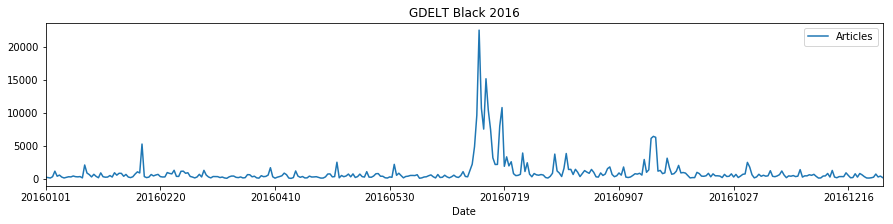

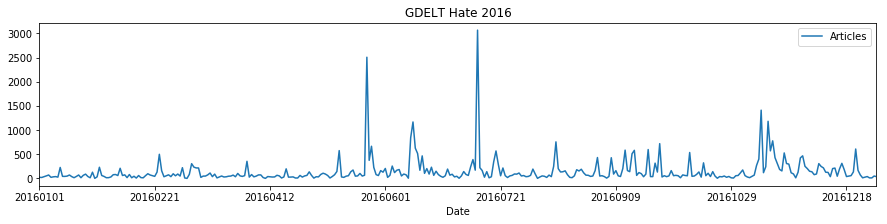

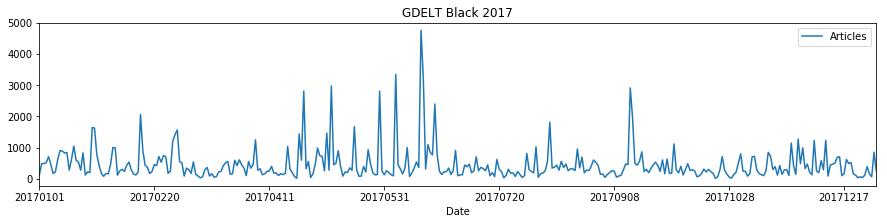

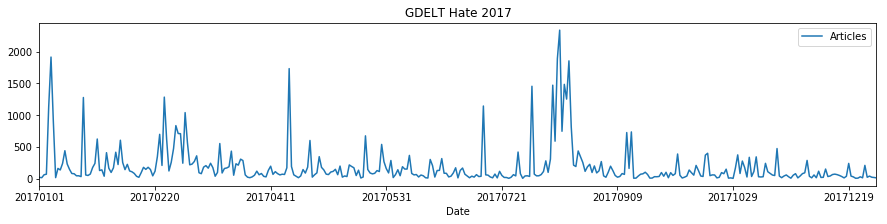

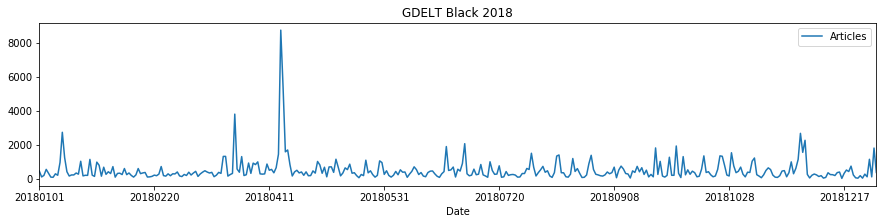

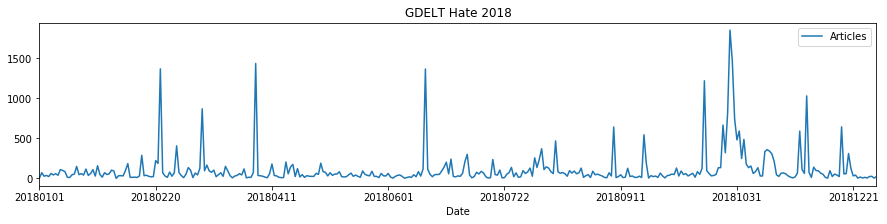

In [35]:
for year in [2016, 2017, 2018]:
    
    cur.execute('''
                select sqldate, sum(numarticles) 
                from gdelt_black
                where left(sqldate, 4)::integer = {0}
                group by sqldate order by sqldate
                '''.format(year))
    
    b_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
    b_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Black {}'.format(year))
    
    cur.execute('''
                select sqldate, sum(numarticles) 
                from gdelt_hate
                where left(sqldate, 4)::integer = {0}
                group by sqldate order by sqldate
                '''.format(year))
    
    h_df = pd.DataFrame([r for r in cur.fetchall()], columns=['Date', 'Articles'])
    h_df.plot(x='Date', y='Articles', figsize=(15, 3), title='GDELT Hate {}'.format(year))


## Explore "Event Windows" Over Time

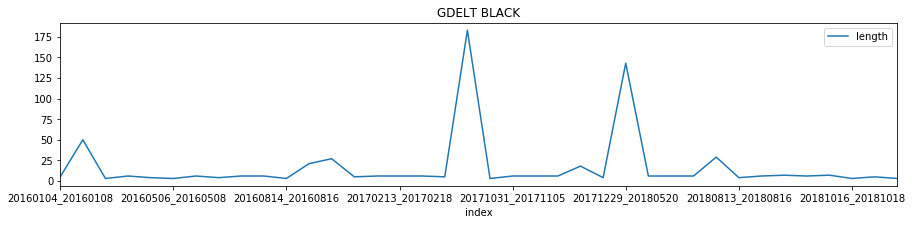

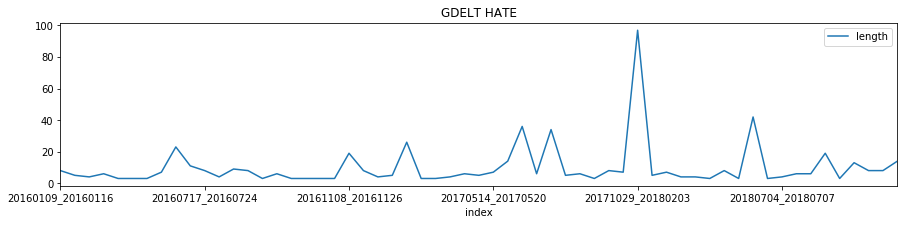

In [36]:
for target in ['black', 'hate']:
    events = json.load(open('gdelt_{}.json'.format(target), 'rb'))
    df = pd.DataFrame.from_dict(events).transpose()
    df.reset_index().plot(x='index', y='length', title='GDELT {}'.format(target.upper()), figsize=(15, 3))

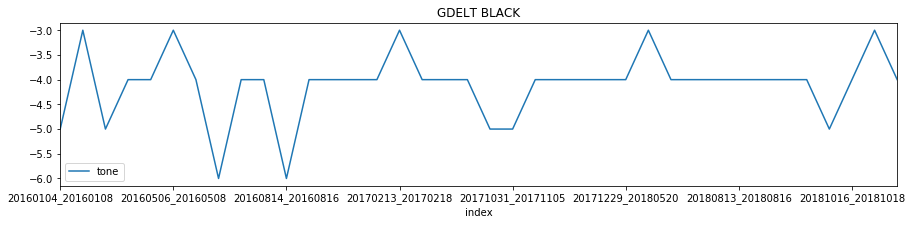

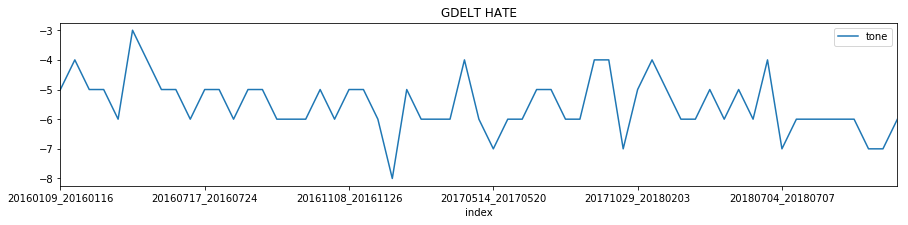

In [37]:
for target in ['black', 'hate']:
    events = json.load(open('gdelt_{}.json'.format(target), 'rb'))
    df = pd.DataFrame.from_dict(events).transpose()
    df.reset_index().plot(x='index', y='tone', title='GDELT {}'.format(target.upper()), figsize=(15, 3))

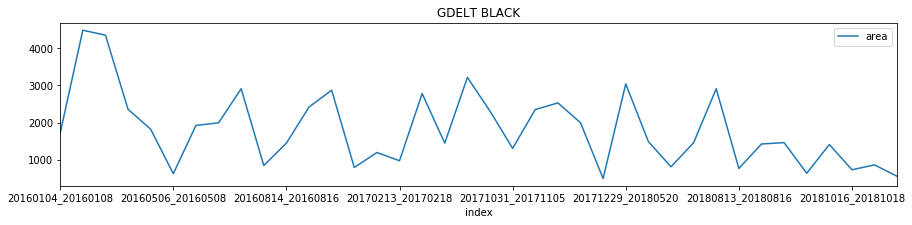

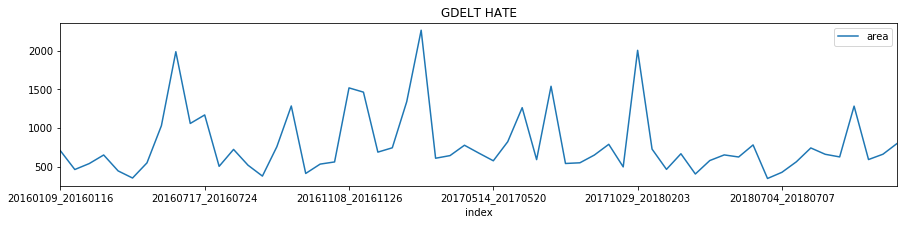

In [38]:
for target in ['black', 'hate']:
    events = json.load(open('gdelt_{}.json'.format(target), 'rb'))
    df = pd.DataFrame.from_dict(events).transpose()
    df.reset_index().plot(x='index', y='area', title='GDELT {}'.format(target.upper()), figsize=(15, 3))

## Clean & Export "Window" Overviews

In [39]:
events = json.load(open('gdelt_black.json'.format(target), 'rb'))
df = pd.DataFrame.from_dict(events).transpose()

a_1 = df['actor_one'].apply(pd.Series)
a_1 = a_1.rename(columns = lambda x : 'a1_' + str(x))
df  = pd.concat([df[:], a_1[:]], axis=1)

a_2 = df['actor_two'].apply(pd.Series)
a_2 = a_2.rename(columns = lambda x : 'a2_' + str(x))
df  = pd.concat([df[:], a_2[:]], axis=1)

keys = df['keywords'].apply(pd.Series)
keys = keys.rename(columns = lambda x : 'k_' + str(x))
df  = pd.concat([df[:], keys[:]], axis=1)

df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "start_end"}, inplace=True)

df['start'] = df['start_end'].apply(lambda x: x[:8])
df['end']   = df['start_end'].apply(lambda x: x[-8:])

df.to_csv('./gdelt_black.csv')
df.head()

,start_end,actor_one,actor_two,area,articles,keywords,length,tone,a1_0,a1_1,...,a2_2,a2_3,a2_4,k_0,k_1,k_2,k_3,k_4,start,end
0,20160104_20160108,"[TEXAS, POLICE OFFICER, ASSOCIATED PRESS, MARC...","[AFRICA, POPULATION, CITIZEN, WRITER, AMERICAN]",1715,2534,"[black, white, matter, lives, oregon]",5,-5,TEXAS,POLICE OFFICER,...,CITIZEN,WRITER,AMERICAN,black,white,matter,lives,oregon,20160104,20160108
1,20160117_20160306,"[MAGAZINE, SUPREME COURT, POPULATION, CALIFORN...","[COMMANDER, FIREFIGHTER, POPULATION, NEW HAMPS...",4484,32365,"[black, white, clinton, sanders, voters]",50,-3,MAGAZINE,SUPREME COURT,...,POPULATION,NEW HAMPSHIRE,CITIZEN,black,white,clinton,sanders,voters,20160117,20160306
2,20160407_20160409,"[POLICE OFFICER, SUPREME COURT, SECRETARY OF S...","[PROTESTER, CLEVELAND, AFAR, ACTIVIST, PHILADE...",4352,2467,"[black, clinton, lives, bill, matter]",3,-5,POLICE OFFICER,SUPREME COURT,...,AFAR,ACTIVIST,PHILADELPHIA,black,clinton,lives,bill,matter,20160407,20160409
3,20160418_20160423,"[SPOKESMAN, AFRICA, POLICE COMMISSIONER, WRITE...","[AFRICA, POPULATION, CITIZEN, ROBBER, CALIFORNIA]",2355,2301,"[black, white, man, clinton, lives]",6,-4,SPOKESMAN,AFRICA,...,CITIZEN,ROBBER,CALIFORNIA,black,white,man,clinton,lives,20160418,20160423
4,20160502_20160505,"[AFRICA, POLITICIAN, PROFESSOR, AMERICAN, PRES...","[WORKER, AFRICA, PROFESSOR, AMERICAN, COMPANY]",1819,1920,"[black, white, man, race, university]",4,-4,AFRICA,POLITICIAN,...,PROFESSOR,AMERICAN,COMPANY,black,white,man,race,university,20160502,20160505


In [40]:
events = json.load(open('gdelt_hate.json'.format(target), 'rb'))
df = pd.DataFrame.from_dict(events).transpose()

a_1 = df['actor_one'].apply(pd.Series)
a_1 = a_1.rename(columns = lambda x : 'a1_' + str(x))
df  = pd.concat([df[:], a_1[:]], axis=1)

a_2 = df['actor_two'].apply(pd.Series)
a_2 = a_2.rename(columns = lambda x : 'a2_' + str(x))
df  = pd.concat([df[:], a_2[:]], axis=1)

keys = df['keywords'].apply(pd.Series)
keys = keys.rename(columns = lambda x : 'k_' + str(x))
df  = pd.concat([df[:], keys[:]], axis=1)

df.reset_index(inplace=True)
df.rename(index=str, columns={"index": "start_end"}, inplace=True)

df['start'] = df['start_end'].apply(lambda x: x[:8])
df['end']   = df['start_end'].apply(lambda x: x[-8:])

df.to_csv('./gdelt_hate.csv')
df.head()

,start_end,actor_one,actor_two,area,articles,keywords,length,tone,a1_0,a1_1,...,a2_2,a2_3,a2_4,k_0,k_1,k_2,k_3,k_4,start,end
0,20160109_20160116,"[GERMANY, WASHINGTON, MUSLIM, LAW ENFORCEMENT ...","[WASHINGTON, MUSLIM, IRAN, SUICIDE BOMBER, PRO...",707,519,"[told, muslims, muslim, arrested, terrorist]",8,-5,GERMANY,WASHINGTON,...,IRAN,SUICIDE BOMBER,PROFESSOR,told,muslims,muslim,arrested,terrorist,20160109,20160116
1,20160127_20160131,"[MAYOR, MUSLIM, SECURITY CHECK, UTAH, SECRETAR...","[LAW ENFORCEMENT AGENCIES, MUSLIM, BOSTON, FLO...",464,387,"[sexual, law, gay, state, victims]",5,-4,MAYOR,MUSLIM,...,BOSTON,FLORIDA,UTAH,sexual,law,gay,state,victims,20160127,20160131
2,20160222_20160225,"[TOURIST, UTAH, RESIDENTS, DISNEY, COLLEGE]","[PORTLAND, VILLAGE, NATIVE AMERICAN, WASHINGTO...",541,828,"[told, black, students, man, bill]",4,-5,TOURIST,UTAH,...,NATIVE AMERICAN,WASHINGTON,MUSLIM,told,black,students,man,bill,20160222,20160225
3,20160307_20160312,"[MUSLIM, SIMON WIESENTHAL CENTER, OKLAHOMA, FL...","[MUSLIM, PUBLICATION, HUMAN RIGHTS ORGANIZATIO...",652,1083,"[center, state, republican, islam, muslims]",6,-5,MUSLIM,SIMON WIESENTHAL CENTER,...,HUMAN RIGHTS ORGANIZATION,FLORIDA,STARBUCKS,center,state,republican,islam,muslims,20160307,20160312
4,20160401_20160403,"[RICHMOND, UNITED STATES, SCHOOL, PROSECUTOR, ...","[UNITED STATES, EMPLOYEE, CITIZEN, GUNMAN, ARI...",446,443,"[world, republican, cant, debate, fox]",3,-6,RICHMOND,UNITED STATES,...,CITIZEN,GUNMAN,ARIZONA,world,republican,cant,debate,fox,20160401,20160403


## SPLC Data

In [107]:
df  = pd.read_csv(r'C:\Users\jeff8977\Desktop\media_research\planning\SPLC\splc-hate-groups-2018.csv')
df.head()

,Title,City,State,Group,Ideology,Headquarters,Statewide,Year
0,Abiding Truth Ministries,Springfield,Massachusetts,NaN,Anti-LGBT,Yes,NaN,2018
1,Alliance Defending Freedom,Scottsdale,Arizona,Alliance Defending Freedom,Anti-LGBT,Yes,NaN,2018
2,American College of Pediatricians,Gainesville,Florida,American College of Pediatricians,Anti-LGBT,Yes,NaN,2018
3,American Family Association,Tupelo,Mississippi,American Family Association,Anti-LGBT,Yes,NaN,2018
4,American Family Association,Franklin,Pennsylvania,American Family Association,Anti-LGBT,NaN,NaN,2018


In [108]:
gb_1 = df.groupby('State')['Title', 'Ideology'].nunique()
gb_2 = df.groupby('State').count()[['Year']]
gb_2.rename(index=str, columns={"Year": "Total"}, inplace=True)
gb_1.merge(gb_2, on="State").to_csv(r'C:\Users\jeff8977\Desktop\media_research\planning\SPLC\splc-2018-metrics.csv')

In [135]:
df16  = pd.read_csv(r'C:\Users\jeff8977\Desktop\media_research\planning\SPLC\splc-2016-metrics.csv')
df16.set_index('State', inplace=True)
df16  = df16.rename(columns = lambda x : '{}_2016'.format(str(x)))

df17  = pd.read_csv(r'C:\Users\jeff8977\Desktop\media_research\planning\SPLC\splc-2017-metrics.csv')
df17.set_index('State', inplace=True)
df17  = df17.rename(columns = lambda x : '{}_2017'.format(str(x)))

df18  = pd.read_csv(r'C:\Users\jeff8977\Desktop\media_research\planning\SPLC\splc-2018-metrics.csv')
df18.set_index('State', inplace=True)
df18  = df18.rename(columns = lambda x : '{}_2018'.format(str(x)))

dfs = [df16, df17, df18]
full_df = dfs[0].join(dfs[1:])

full_df['Ideo_Diff_16_18'] = full_df.apply(lambda row: row.Ideology_2018 - row.Ideology_2016, axis=1)
full_df.sort_values('Total_2018', ascending=0)

,Title_2016,Ideology_2016,Total_2016,Title_2017,Ideology_2017,Total_2017,Title_2018,Ideology_2018,Total_2018,Ideo_Diff_16_18
State,,,,,,,,,,
California,59,13,79,61,12,75,61.0,12.0,83.0,-1.0
Florida,40,12,63,47,13,66,51.0,11.0,75.0,-1.0
Texas,38,13,55,45,15,66,55.0,14.0,73.0,1.0
New York,41,12,47,42,11,48,40.0,11.0,47.0,-1.0
Georgia,24,9,32,34,12,40,34.0,11.0,41.0,2.0
North Carolina,24,9,31,27,9,32,30.0,10.0,40.0,1.0
Virginia,36,12,39,35,12,37,37.0,11.0,39.0,-1.0
Ohio,27,9,35,25,8,31,29.0,11.0,36.0,2.0
Tennessee,28,8,38,31,9,37,30.0,9.0,36.0,1.0
